In [1]:
import tensorflow as tf
import tensorflow_hub as hub

# Augmenting data and storing as new datapoints

In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf
import pandas as pd
import random

# Paths
dataset_dir = "/home/maditya/Desktop/Front Era/Datasets"  # Original dataset
augmented_dir = "Augmented_Dataset"  # Folder for augmented data
os.makedirs(augmented_dir, exist_ok=True)  # Ensure base folder exists

# Define class names
classes = ["Cry", "Scream", "Normal"]

# Function to apply random augmentation
def augment_audio(y, sr):
    """Applies a random augmentation to the audio waveform."""
    aug_type = random.choice(["time_stretch", "pitch_shift", "add_noise", "time_shift", "volume"])

    if aug_type == "time_stretch":
        rate = random.uniform(0.9, 1.1)
        y = librosa.effects.time_stretch(y=y, rate=rate)

    elif aug_type == "pitch_shift":
        steps = random.randint(-2, 2)
        y = librosa.effects.pitch_shift(y = y, sr=sr, n_steps=steps)

    elif aug_type == "add_noise":
        noise = np.random.normal(0, 0.005, y.shape)
        y = y + noise

    elif aug_type == "time_shift":
        shift = int(sr * random.uniform(-0.1, 0.1))
        y = np.roll(y, shift)

    elif aug_type == "volume":
        gain = random.uniform(0.8, 1.2)
        y = y * gain

    return np.clip(y, -1.0, 1.0)  # Clip to avoid distortion

# Prepare CSV data storage
data = []

# Process each class folder
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)  # Path to original class folder
    aug_class_dir = os.path.join(augmented_dir, class_name)  # Path to augmented class folder
    os.makedirs(aug_class_dir, exist_ok=True)  # Create folder if it doesn't exist

    # Get all WAV files
    files = sorted(f for f in os.listdir(class_dir) if f.endswith(".wav"))

    # Process each file
    for file_name in files:
        original_path = os.path.join(class_dir, file_name)  # Original file path

        # Load the audio
        y, sr = librosa.load(original_path, sr=16000, mono=True)

        # Apply augmentation
        y_aug = augment_audio(y, sr)

        # Save the augmented file
        new_filename = file_name.replace(".wav", "_aug1.wav")
        aug_path = os.path.join(aug_class_dir, new_filename)
        sf.write(aug_path, y_aug, sr, subtype="PCM_16")

        # Store in CSV data
        data.append([new_filename, class_name.lower()])

# Convert to DataFrame and save CSV
df = pd.DataFrame(data, columns=["filename", "label"])
csv_path = os.path.join(augmented_dir, "augmented_dataset.csv")
df.to_csv(csv_path, index=False)

print(f"Augmentation complete! Augmented files saved in '{augmented_dir}'.")
print(f"CSV file saved at '{csv_path}'.")


Augmentation complete! Augmented files saved in 'Augmented_Dataset'.
CSV file saved at 'Augmented_Dataset/augmented_dataset.csv'.


# Creating a big dataset out of both datasets

In [ ]:
import os
import shutil
import pandas as pd
import random

# Define dataset paths
original_dataset = "/home/maditya/Desktop/Front Era/Datasets"  # Folder with original dataset
augmented_dataset = "/home/maditya/Desktop/Front Era/Augmented_Dataset"  # Folder with augmented dataset
final_dataset = "Final_Dataset_with_aug"  # New merged dataset

# Ensure the Final_Dataset exists
os.makedirs(final_dataset, exist_ok=True)

# Define class names
classes = ["Cry", "Scream", "Normal"]

# Initialize a list to store CSV data
data = []

# Process each class
for class_name in classes:
    orig_class_dir = os.path.join(original_dataset, class_name)
    aug_class_dir = os.path.join(augmented_dataset, class_name)
    final_class_dir = os.path.join(final_dataset, class_name)

    # Ensure the class folder exists in Final_Dataset
    os.makedirs(final_class_dir, exist_ok=True)

    # Collect original files
    if os.path.exists(orig_class_dir):
        for file_name in sorted(os.listdir(orig_class_dir)):
            if file_name.endswith(".wav"):
                src_path = os.path.join(orig_class_dir, file_name)
                dest_path = os.path.join(final_class_dir, file_name)  # Keep original name
                shutil.copy2(src_path, dest_path)
                data.append([file_name, class_name.lower()])  # Store in CSV

    # Collect augmented files
    if os.path.exists(aug_class_dir):
        for file_name in sorted(os.listdir(aug_class_dir)):
            if file_name.endswith(".wav"):
                src_path = os.path.join(aug_class_dir, file_name)
                dest_path = os.path.join(final_class_dir, file_name)  # Keep _aug in name
                shutil.copy2(src_path, dest_path)
                data.append([file_name, class_name.lower()])  # Store in CSV

    # Shuffle files inside the class folder
    files = os.listdir(final_class_dir)
    random.shuffle(files)  # Shuffle file order

    # Rename shuffled files to maintain randomness
    for i, file_name in enumerate(files, start=1):
        old_path = os.path.join(final_class_dir, file_name)

        # Check if the file is augmented or original
        if "_aug" in file_name:
            new_filename = f"{class_name.lower()}_{i:03d}_aug.wav"
        else:
            new_filename = f"{class_name.lower()}_{i:03d}.wav"

        new_path = os.path.join(final_class_dir, new_filename)
        os.rename(old_path, new_path)

        # Update CSV with new filenames
        for entry in data:
            if entry[0] == file_name:
                entry[0] = new_filename

# Shuffle the entire dataset list for randomness
random.shuffle(data)

# Convert to DataFrame and save CSV
df = pd.DataFrame(data, columns=["filename", "label"])
csv_path = os.path.join(final_dataset, "final_dataset.csv")
df.to_csv(csv_path, index=False)

print(f"Dataset merging & shuffling complete! Final dataset stored in '{final_dataset}/'")
print(f"Final shuffled CSV saved at '{csv_path}'")

Dataset merging & shuffling complete! Final dataset stored in 'Final_Dataset_with_aug/'
Final shuffled CSV saved at 'Final_Dataset_with_aug/final_dataset.csv'


# Storing embeddings of all files from Final Dataset

In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import soundfile as sf
import pandas as pd

# Load the YAMNet model
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

# Define input and output directories
input_dir = "/home/maditya/Desktop/Front Era/Final_Dataset_with_aug"  # Folder with WAV files
output_dir = "Final_Embeddings"  # Folder to store embeddings
os.makedirs(output_dir, exist_ok=True)  # Ensure base folder exists

# Class names
classes = ["Cry", "Scream", "Normal"]

# Function to load and process an audio file
def load_wav_file(wav_path, target_sample_rate=16000):
    """Loads a WAV file and resamples it to 16kHz mono."""
    wav_data, sample_rate = sf.read(wav_path, dtype="float32")

    # If stereo, take only one channel
    if len(wav_data.shape) > 1:
        wav_data = np.mean(wav_data, axis=1)

    return wav_data, target_sample_rate

# Function to get YAMNet embeddings
def get_yamnet_embeddings(wav_path):
    """Extracts YAMNet embeddings from a WAV file."""
    waveform, _ = load_wav_file(wav_path)
    _, embeddings, _ = yamnet_model(waveform)  # We only need embeddings
    return embeddings.numpy()

# Function to save embeddings
def save_embeddings(wav_path, embeddings):
    """Saves embeddings to a .npy file while preserving the correct shape."""
    filename = os.path.basename(wav_path).replace(".wav", ".npy")  # Change extension
    class_label = os.path.basename(os.path.dirname(wav_path))  # Get class name
    class_dir = os.path.join(output_dir, class_label)  # Output class folder
    os.makedirs(class_dir, exist_ok=True)  # Ensure class folder exists

    save_path = os.path.join(class_dir, filename)  # Full path to save embeddings
    np.save(save_path, embeddings)  # Save in .npy format

    return filename, class_label  # Return metadata for CSV

# List to store metadata
metadata = []

# Process each class folder
for class_name in classes:
    class_folder = os.path.join(input_dir, class_name)  # Path to WAV files
    if not os.path.exists(class_folder):
        print(f"Skipping missing folder: {class_folder}")
        continue

    # Process each WAV file
    for file_name in sorted(os.listdir(class_folder)):
        if file_name.endswith(".wav"):
            wav_path = os.path.join(class_folder, file_name)

            # Extract embeddings
            embeddings = get_yamnet_embeddings(wav_path)

            # Save embeddings and get metadata
            embedding_filename, class_label = save_embeddings(wav_path, embeddings)

            # Add metadata entry (embedding file, original wav file, class)
            metadata.append([embedding_filename, file_name, class_label])

# Convert metadata to DataFrame and save as CSV
metadata_df = pd.DataFrame(metadata, columns=["embedding_file", "original_wav", "label"])
csv_path = os.path.join(output_dir, "embeddings_metadata.csv")
metadata_df.to_csv(csv_path, index=False)

print(f"Embedding extraction complete! Embeddings saved in '{output_dir}/'")
print(f"Metadata CSV saved at '{csv_path}'")


Embedding extraction complete! Embeddings saved in 'Final_Embeddings/'
Metadata CSV saved at 'Final_Embeddings/embeddings_metadata.csv'


In [ ]:
embedding_file = "/home/maditya/Desktop/Front Era/Final_Embeddings/Cry/cry_001.npy"

# Load the .npy file
embedding = np.load(embedding_file)

# Print the shape
print("Embedding shape:", embedding.shape)


Embedding shape: (14, 1024)


# Define FFNN for classifying the embedding dataset
HOw to pass embedding of shape (N, 1024) ? Two approaches
* If your dataset is small and you just want to classify entire audio files into broad categories, aggregation (mean pooling) is a strong baseline.
* If your dataset is larger and you suspect temporal patterns (the order/timing of sounds) are important, consider a sequential model.

### Butfirst lets, mean pool the embeddings and create a new folder

In [ ]:
import os
import numpy as np
import pandas as pd

# Paths
input_dir = "/home/maditya/Desktop/Front Era/Final_Embeddings"
output_dir = "Mean_Pooled_Final_embeddings"
os.makedirs(output_dir, exist_ok=True)

# Classes
classes = ["Cry", "Scream", "Normal"]

# List to store metadata: [mean_pooled_filename, label]
metadata = []

# Process each class subfolder
for class_name in classes:
    # Paths for input and output subfolders
    input_class_dir = os.path.join(input_dir, class_name)
    output_class_dir = os.path.join(output_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)

    # Iterate over all .npy embedding files
    for file_name in sorted(os.listdir(input_class_dir)):
        if file_name.endswith(".npy"):
            file_path = os.path.join(input_class_dir, file_name)

            # Load embeddings => shape: (N, 1024)
            embeddings = np.load(file_path)

            # Mean pooling across time dimension => shape: (1024,)
            mean_emb = np.mean(embeddings, axis=0)

            # Save the mean-pooled embedding with the same filename
            output_path = os.path.join(output_class_dir, file_name)
            np.save(output_path, mean_emb)

            # Record metadata (filename, label)
            metadata.append([file_name, class_name.lower()])

# Create a DataFrame and save CSV
df = pd.DataFrame(metadata, columns=["filename", "label"])
csv_path = os.path.join(output_dir, "mean_pooled_metadata.csv")
df.to_csv(csv_path, index=False)

print(f"Mean pooling complete! Files saved in '{output_dir}' with subfolders for each class.")
print(f"Metadata CSV saved at: {csv_path}")


Mean pooling complete! Files saved in 'Mean_Pooled_Final_embeddings' with subfolders for each class.
Metadata CSV saved at: Mean_Pooled_Final_embeddings/mean_pooled_metadata.csv


### Confirm if correct shape

In [ ]:
# Path to an example mean-pooled embedding file
embedding_file = "/home/maditya/Desktop/Front Era/Mean_Pooled_Final_embeddings/Cry/cry_001.npy"

# Load the .npy file
embedding = np.load(embedding_file)

# Print the shape
print("Embedding shape:", embedding.shape)

Embedding shape: (1024,)


# Creating Train, Test and Val splits

### First move all embeddings into one folder

In [ ]:
import os
import shutil
import pandas as pd

# Paths
input_dir = "/home/maditya/Desktop/Front Era/Mean_Pooled_Final_embeddings"
output_dir = "Final_under_one_folder_embeddings"#s together
os.makedirs(output_dir, exist_ok=True)

# Classes
classes = ["Cry", "Scream", "Normal"]

# Prepare a list to store metadata: [filename, label]
metadata = []

# Loop through each class folder
for class_name in classes:
    class_folder = os.path.join(input_dir, class_name)
    if not os.path.exists(class_folder):
        print(f"Skipping missing folder: {class_folder}")
        continue

    # For each .npy file in the class subfolder
    for file_name in sorted(os.listdir(class_folder)):
        if file_name.endswith(".npy"):
            src_path = os.path.join(class_folder, file_name)
            dest_path = os.path.join(output_dir, file_name)

            # Copy (or move) the file to the single folder
            shutil.copy2(src_path, dest_path)

            # Record the label and filename in metadata
            metadata.append([file_name, class_name.lower()])

# Convert metadata to DataFrame
df = pd.DataFrame(metadata, columns=["filename", "label"])

# Save the CSV inside 'all_files_under_main'
csv_path = os.path.join(output_dir, "all_files_under_main.csv")
df.to_csv(csv_path, index=False)

print(f"All .npy files consolidated in '{output_dir}'")
print(f"Metadata CSV saved at '{csv_path}'")


All .npy files consolidated in 'Final_under_one_folder_embeddings'
Metadata CSV saved at 'Final_under_one_folder_embeddings/all_files_under_main.csv'


### SHuffling data in embedding folder
WARNING :- THIS RENAMES THE FILE NAMES TOO
GO BACK TO OTHER FOLDER AND RESTORE IF YOU WANT

In [ ]:
import os
import pandas as pd
import random
import shutil

# Paths
folder_path ="/home/maditya/Desktop/Front Era/Final_embeddings_folder"
csv_path = os.path.join(folder_path,"/home/maditya/Desktop/Front Era/final_embed_meta_data.csv")

# Load the metadata CSV
df = pd.read_csv(csv_path)

# Shuffle the rows randomly
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Rename files in shuffled order
new_filenames = []
for i, row in df.iterrows():
    old_filename = row["filename"]
    old_filepath = os.path.join(folder_path, old_filename)

    # Generate new randomized name while keeping .npy extension
    new_filename = f"file_{i:05d}.npy"
    new_filepath = os.path.join(folder_path, new_filename)

    # Rename the file
    shutil.move(old_filepath, new_filepath)

    # Store new filename in metadata
    new_filenames.append(new_filename)

# Update the dataframe with new shuffled filenames
df["filename"] = new_filenames

# Save the updated shuffled CSV
df.to_csv(csv_path, index=False)

print(f"Dataset and CSV shuffled successfully! Updated file names stored in: {csv_path}")


Dataset and CSV shuffled successfully! Updated file names stored in: /home/maditya/Desktop/Front Era/final_embed_meta_data.csv


### Splitting and storing

In [ ]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

# Paths
input_folder = "/home/maditya/Desktop/Front Era/Final_embeddings_folder"
output_folder = "split_dataset"  # Folder to store train/val/test sets
os.makedirs(output_folder, exist_ok=True)

# Load shuffled metadata
csv_path = os.path.join(input_folder, "/home/maditya/Desktop/Front Era/final_embed_meta_data.csv")
df = pd.read_csv(csv_path)

# Stratified split into train (70%), temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=42)

# Further split temp into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42)

# Function to move files into split folders
def move_files(df, split_name):
    split_path = os.path.join(output_folder, split_name)
    os.makedirs(split_path, exist_ok=True)

    for _, row in df.iterrows():
        src = os.path.join(input_folder, row["filename"])
        dst = os.path.join(split_path, row["filename"])
        shutil.move(src, dst)  # Move file to respective split folder

# Move files into respective folders
move_files(train_df, "train")
move_files(val_df, "val")
move_files(test_df, "test")

# Save split CSVs
train_df.to_csv(os.path.join(output_folder, "train.csv"), index=False)
val_df.to_csv(os.path.join(output_folder, "val.csv"), index=False)
test_df.to_csv(os.path.join(output_folder, "test.csv"), index=False)

print("Dataset split completed! Train, validation, and test sets are ready.")


Dataset split completed! Train, validation, and test sets are ready.


### Encoding Labels
 {"cry": 0, "scream": 1, "normal": 2}

In [ ]:
import pandas as pd
import os

# Path to dataset splits
dataset_splits = ["train", "val", "test"]
base_path = "/home/maditya/Desktop/Front Era/split_dataset"

# Encoding dictionary
label_mapping = {"cry": 0, "scream": 1, "normal": 2}

# Process each dataset split
for split in dataset_splits:
    csv_path = os.path.join(base_path, f"{split}.csv")

    # Load CSV
    df = pd.read_csv(csv_path)

    # Encode labels
    df["encoded_label"] = df["label"].map(label_mapping)

    # Save updated CSV
    df.to_csv(csv_path, index=False)

print("Labels encoded successfully! Updated CSVs saved in 'split_dataset/'")


Labels encoded successfully! Updated CSVs saved in 'split_dataset/'


# Defining the FFNN

In [ ]:
lr = 1e-3
batch_size = 32
num_epochs = 10

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the FFNN model
def create_ffnn(lr):
    model = keras.Sequential([
        layers.Input(shape=(1024,)),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dense(3, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Create model
ffnn_model = create_ffnn(0.001)
ffnn_model.summary()

W0000 00:00:1740278774.404346    5136 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,411 (2.63 MB)

 Trainable params: 689,411 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

# Load Data for Training

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

# Paths
dataset_dir = "/home/maditya/Desktop/Front Era/Model1 :- YamNet/split_dataset"

# Function to load data from a CSV and corresponding .npy files
def load_data(split):
    """Loads embeddings and labels from the given split (train/val/test)."""
    csv_path = os.path.join(dataset_dir, f"{split}.csv")  # Path to metadata CSV
    df = pd.read_csv(csv_path)  # Load metadata

    embeddings = []  # Store feature vectors
    labels = []      # Store class labels

    split_folder = os.path.join(dataset_dir, split)  # Path to .npy files

    for _, row in df.iterrows():
        file_path = os.path.join(split_folder, row["filename"])  # Get .npy file path
        embedding = np.load(file_path)  # Load the (1024,) embedding
        embeddings.append(embedding)  # Store in list
        labels.append(row["encoded_label"])  # Store encoded class label

    # Convert lists to NumPy arrays
    embeddings = np.array(embeddings)  # Shape: (num_samples, 1024)
    labels = np.array(labels)  # Shape: (num_samples,)

    # Shuffle the dataset for randomness
    embeddings, labels = shuffle(embeddings, labels, random_state=42)

    return embeddings, labels

# Load training, validation, and test sets
X_train, y_train = load_data("train")
X_val, y_val = load_data("val")
X_test, y_test = load_data("test")

# Print shapes to verify
print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")


Training set: (2740, 1024), Labels: (2740,)
Validation set: (587, 1024), Labels: (587,)
Test set: (588, 1024), Labels: (588,)


### Saving Test Data

In [ ]:
# Save test data to a compressed file
np.savez_compressed("test_data_yamnet.npz", X_test=X_test, y_test=y_test)

print("✅ Test data saved successfully!")

✅ Test data saved successfully!


# HyperParameter Tuning with K-fold-CrossValidation

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [ ]:
hyperparams = [
    {"learning_rate": 0.001, "epochs": 30, "batch_size": 32},
    {"learning_rate": 0.0005, "epochs": 40, "batch_size": 64},
    {"learning_rate": 0.01,"epochs": 50, "batch_size": 16},
    {"learning_rate": 0.002, "epochs": 25, "batch_size": 32},
    {"learning_rate": 0.0003, "epochs": 35, "batch_size": 64},
]

In [ ]:
# K-Fold setup
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

In [ ]:
from tensorflow.keras.backend import clear_session

In [ ]:
# Run cross-validation for each hyperparameter combo
for i, params in enumerate(hyperparams):
    print(f"\n Testing Combo {i+1}: LR={params['learning_rate']}, Epochs={params['epochs']}, Batch Size={params['batch_size']}")

    fold_accuracies = []

    # 5-Fold Cross Validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"Fold {fold+1}...")

        # Create train/validation splits
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        clear_session()

        # Create and train model
        model = create_ffnn(params["learning_rate"])
        model.fit(X_train_fold, y_train_fold,
                  epochs=params["epochs"],
                  batch_size=params["batch_size"],
                  validation_data=(X_val_fold, y_val_fold),
                  verbose=0)  # Silent training to keep console clean

        # Evaluate model on validation fold
        _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        fold_accuracies.append(accuracy)

    # Compute average accuracy across folds
    avg_accuracy = np.mean(fold_accuracies)
    print(f"Average Accuracy over {K} folds: {avg_accuracy:.4f}")


 Testing Combo 1: LR=0.001, Epochs=30, Batch Size=32
Fold 1...
Fold 2...
Fold 3...
Fold 4...
Fold 5...
Average Accuracy over 5 folds: 0.9752

 Testing Combo 2: LR=0.0005, Epochs=40, Batch Size=64
Fold 1...
Fold 2...
Fold 3...
Fold 4...
Fold 5...
Average Accuracy over 5 folds: 0.9730

 Testing Combo 3: LR=0.01, Epochs=50, Batch Size=16
Fold 1...
Fold 2...
Fold 3...
Fold 4...
Fold 5...
Average Accuracy over 5 folds: 0.9416

 Testing Combo 4: LR=0.002, Epochs=25, Batch Size=32
Fold 1...
Fold 2...
Fold 3...
Fold 4...
Fold 5...
Average Accuracy over 5 folds: 0.9682

 Testing Combo 5: LR=0.0003, Epochs=35, Batch Size=64
Fold 1...
Fold 2...
Fold 3...
Fold 4...
Fold 5...
Average Accuracy over 5 folds: 0.9759


Best Combination of HyperParameters is
* Learning Rate :- 0.001
* Batch Size = 32
* NUmber of epochs = 30

# Training model on best hyperparameters

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 30
BATCH_SIZE = 32

In [ ]:
def create_ffnn():
    model = keras.Sequential([
        layers.Input(shape=(1024,)),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dense(3, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Create model
model = create_ffnn()

### Training Loop

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

Epoch 1/30


Training: 100%|██████████| 85/85 [00:00<00:00, 124.82batch/s]


Train Acc: 0.9058 | Val Acc: 0.9216 | Train F1: 0.9196 | Val F1: 0.9175
Epoch 2/30


Training: 100%|██████████| 85/85 [00:00<00:00, 369.88batch/s]


Train Acc: 0.9595 | Val Acc: 0.9676 | Train F1: 0.9713 | Val F1: 0.9660
Epoch 3/30


Training: 100%|██████████| 85/85 [00:00<00:00, 368.40batch/s]


Train Acc: 0.9675 | Val Acc: 0.9540 | Train F1: 0.9711 | Val F1: 0.9511
Epoch 4/30


Training: 100%|██████████| 85/85 [00:00<00:00, 370.62batch/s]


Train Acc: 0.9701 | Val Acc: 0.9676 | Train F1: 0.9742 | Val F1: 0.9663
Epoch 5/30


Training: 100%|██████████| 85/85 [00:00<00:00, 369.92batch/s]


Train Acc: 0.9672 | Val Acc: 0.9591 | Train F1: 0.9661 | Val F1: 0.9569
Epoch 6/30


Training: 100%|██████████| 85/85 [00:00<00:00, 376.19batch/s]


Train Acc: 0.9799 | Val Acc: 0.9642 | Train F1: 0.9677 | Val F1: 0.9627
Epoch 7/30


Training: 100%|██████████| 85/85 [00:00<00:00, 378.67batch/s]


Train Acc: 0.9777 | Val Acc: 0.9676 | Train F1: 0.9860 | Val F1: 0.9646
Epoch 8/30


Training: 100%|██████████| 85/85 [00:00<00:00, 372.21batch/s]


Train Acc: 0.9810 | Val Acc: 0.9744 | Train F1: 0.9934 | Val F1: 0.9734
Epoch 9/30


Training: 100%|██████████| 85/85 [00:00<00:00, 371.01batch/s]


Train Acc: 0.9843 | Val Acc: 0.9659 | Train F1: 0.9870 | Val F1: 0.9645
Epoch 10/30


Training: 100%|██████████| 85/85 [00:00<00:00, 382.72batch/s]


Train Acc: 0.9865 | Val Acc: 0.9659 | Train F1: 0.9895 | Val F1: 0.9639
Epoch 11/30


Training: 100%|██████████| 85/85 [00:00<00:00, 377.64batch/s]


Train Acc: 0.9909 | Val Acc: 0.9676 | Train F1: 0.9886 | Val F1: 0.9658
Epoch 12/30


Training: 100%|██████████| 85/85 [00:00<00:00, 376.07batch/s]


Train Acc: 0.9810 | Val Acc: 0.9710 | Train F1: 0.9921 | Val F1: 0.9689
Epoch 13/30


Training: 100%|██████████| 85/85 [00:00<00:00, 389.26batch/s]


Train Acc: 0.9901 | Val Acc: 0.9574 | Train F1: 0.9922 | Val F1: 0.9557
Epoch 14/30


Training: 100%|██████████| 85/85 [00:00<00:00, 386.18batch/s]


Train Acc: 0.9912 | Val Acc: 0.9676 | Train F1: 0.9920 | Val F1: 0.9664
Epoch 15/30


Training: 100%|██████████| 85/85 [00:00<00:00, 366.18batch/s]


Train Acc: 0.9953 | Val Acc: 0.9761 | Train F1: 0.9964 | Val F1: 0.9745
Epoch 16/30


Training: 100%|██████████| 85/85 [00:00<00:00, 379.71batch/s]


Train Acc: 0.9938 | Val Acc: 0.9727 | Train F1: 0.9970 | Val F1: 0.9712
Epoch 17/30


Training: 100%|██████████| 85/85 [00:00<00:00, 379.77batch/s]


Train Acc: 0.9894 | Val Acc: 0.9642 | Train F1: 0.9905 | Val F1: 0.9628
Epoch 18/30


Training: 100%|██████████| 85/85 [00:00<00:00, 376.84batch/s]


Train Acc: 0.9927 | Val Acc: 0.9710 | Train F1: 0.9977 | Val F1: 0.9700
Epoch 19/30


Training: 100%|██████████| 85/85 [00:00<00:00, 369.60batch/s]


Train Acc: 0.9956 | Val Acc: 0.9727 | Train F1: 0.9940 | Val F1: 0.9715
Epoch 20/30


Training: 100%|██████████| 85/85 [00:00<00:00, 377.53batch/s]


Train Acc: 0.9894 | Val Acc: 0.9710 | Train F1: 0.9953 | Val F1: 0.9689
Epoch 21/30


Training: 100%|██████████| 85/85 [00:00<00:00, 384.02batch/s]


Train Acc: 0.9927 | Val Acc: 0.9761 | Train F1: 0.9966 | Val F1: 0.9745
Epoch 22/30


Training: 100%|██████████| 85/85 [00:00<00:00, 384.00batch/s]


Train Acc: 0.9953 | Val Acc: 0.9676 | Train F1: 0.9908 | Val F1: 0.9649
Epoch 23/30


Training: 100%|██████████| 85/85 [00:00<00:00, 372.50batch/s]


Train Acc: 0.9945 | Val Acc: 0.9761 | Train F1: 0.9974 | Val F1: 0.9753
Epoch 24/30


Training: 100%|██████████| 85/85 [00:00<00:00, 381.06batch/s]


Train Acc: 0.9949 | Val Acc: 0.9676 | Train F1: 0.9914 | Val F1: 0.9655
Epoch 25/30


Training: 100%|██████████| 85/85 [00:00<00:00, 374.74batch/s]


Train Acc: 0.9923 | Val Acc: 0.9625 | Train F1: 0.9903 | Val F1: 0.9610
Epoch 26/30


Training: 100%|██████████| 85/85 [00:00<00:00, 367.40batch/s]


Train Acc: 0.9887 | Val Acc: 0.9796 | Train F1: 0.9881 | Val F1: 0.9787
Epoch 27/30


Training: 100%|██████████| 85/85 [00:00<00:00, 385.67batch/s]


Train Acc: 0.9971 | Val Acc: 0.9710 | Train F1: 0.9973 | Val F1: 0.9695
Epoch 28/30


Training: 100%|██████████| 85/85 [00:00<00:00, 384.10batch/s]


Train Acc: 0.9949 | Val Acc: 0.9693 | Train F1: 0.9974 | Val F1: 0.9681
Epoch 29/30


Training: 100%|██████████| 85/85 [00:00<00:00, 360.36batch/s]


Train Acc: 0.9942 | Val Acc: 0.9625 | Train F1: 0.9925 | Val F1: 0.9603
Epoch 30/30


Training: 100%|██████████| 85/85 [00:00<00:00, 386.35batch/s]

Train Acc: 0.9880 | Val Acc: 0.9727 | Train F1: 0.9981 | Val F1: 0.9715


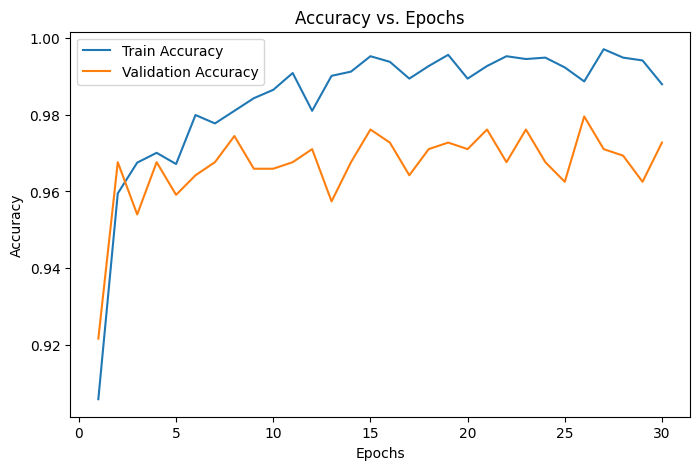

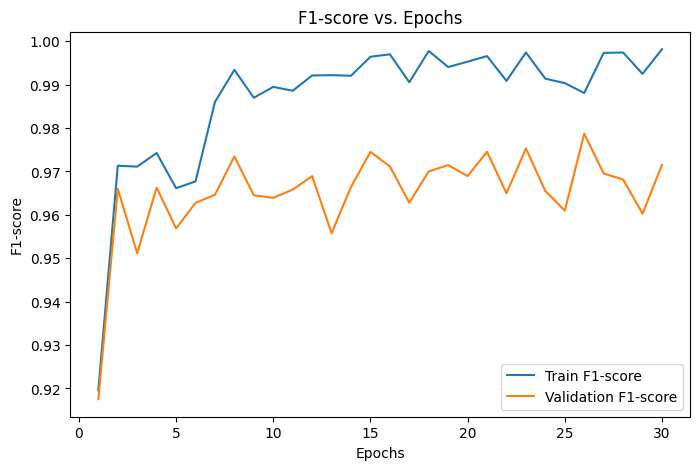

Training Complete! Ready to evaluate on the test set.


In [ ]:
# Track metrics
train_acc_list, val_acc_list = [], []
train_f1_list, val_f1_list = [], []

# Custom training loop with progress bar & F1-score tracking
for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")

    # Train model for one epoch with progress bar
    with tqdm(total=len(X_train) // BATCH_SIZE, desc="Training", unit="batch") as pbar:
        history = model.fit(X_train, y_train,
                            batch_size=BATCH_SIZE,
                            epochs=1,  # One epoch at a time
                            validation_data=(X_val, y_val),
                            verbose=0)  # Silent training to keep output clean
        pbar.update(len(X_train) // BATCH_SIZE)

    # Get train & val accuracy
    train_acc = history.history["accuracy"][0]
    val_acc = history.history["val_accuracy"][0]
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    # Predict on train & val sets to compute Precision, Recall, F1-score
    y_train_pred = np.argmax(model.predict(X_train, verbose=0), axis=1)
    y_val_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)

    # Compute classification metrics
    train_report = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
    val_report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)

    # Extract Precision, Recall, and F1-score
    train_f1 = train_report["macro avg"]["f1-score"]
    val_f1 = val_report["macro avg"]["f1-score"]
    train_f1_list.append(train_f1)
    val_f1_list.append(val_f1)

    # Print Metrics
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

# Plot Accuracy vs. Epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_acc_list, label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), val_acc_list, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")
plt.legend()
plt.show()

# Plot F1-score vs. Epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_f1_list, label="Train F1-score")
plt.plot(range(1, EPOCHS + 1), val_f1_list, label="Validation F1-score")
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.title("F1-score vs. Epochs")
plt.legend()
plt.show()

print("Training Complete! Ready to evaluate on the test set.")

# Save the model

In [ ]:
model.save("final_YamNet_classifier.h5")
print("Model saved as 'final_audio_classifier.h5'")

Model saved as 'final_audio_classifier.h5'


# Load the model

In [ ]:
import os

# 🔹 Disable GPU for TensorFlow
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"  # (Optional) Disable OneDNN optimizations

import tensorflow as tf

In [2]:
model = tf.keras.models.load_model("/content/final_YamNet_classifier.h5")

# Evaluate on Test Set

In [4]:
# Load the test dataset
import numpy as np

data = np.load("/content/test_data_yamnet.npz")

# Extract features & labels
X_test = data["X_test"]
y_test = data["y_test"]

print(f"Loaded Test Data: {X_test.shape}, Labels: {y_test.shape}")


Loaded Test Data: (588, 1024), Labels: (588,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9797 - loss: 0.0868
Test Accuracy: 0.9779
Classification Report:
              precision    recall  f1-score   support

         Cry       0.96      0.97      0.97       146
      Scream       0.97      0.97      0.97       216
      Normal       1.00      0.99      0.99       226

    accuracy                           0.98       588
   macro avg       0.98      0.98      0.98       588
weighted avg       0.98      0.98      0.98       588



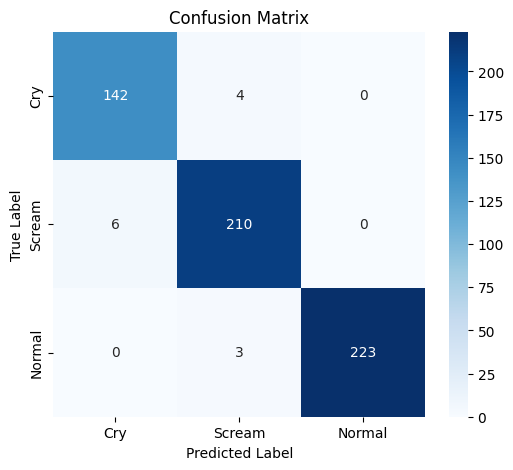

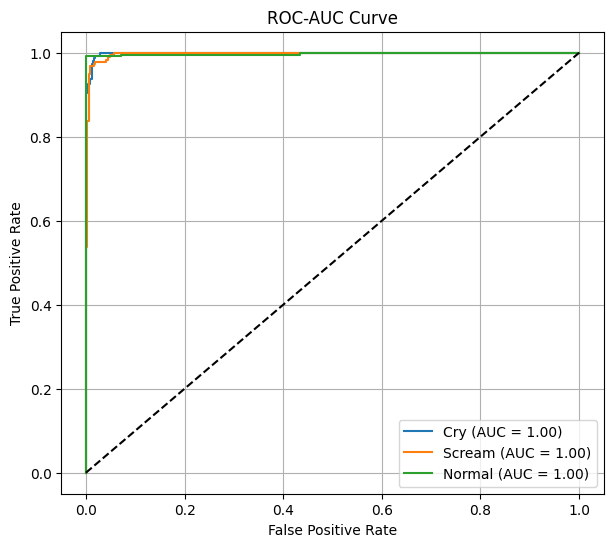

✅ Evaluation Completed!


In [5]:
import numpy as np
# import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# ✅ Load test data
# X_test, y_test = np.load("split_dataset/test.npy"), np.load("split_dataset/test_labels.npy")

# ✅ Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

# ✅ Get class probabilities & predictions
y_probs = model.predict(X_test, verbose=0)  # Probabilities (shape: num_samples x num_classes)
y_pred = np.argmax(y_probs, axis=1)  # Predicted class labels

# ✅ Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Cry", "Scream", "Normal"]))

# ✅ Generate & Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cry", "Scream", "Normal"], yticklabels=["Cry", "Scream", "Normal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ✅ Convert labels to One-Hot Encoding for ROC-AUC Calculation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Convert to one-hot format

# ✅ Plot ROC-AUC Curves
plt.figure(figsize=(7, 6))
for i, class_name in enumerate(["Cry", "Scream", "Normal"]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")  # Plot each class

# ✅ Final Plot Settings
plt.plot([0, 1], [0, 1], "k--")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.grid()
plt.show()

print("✅ Evaluation Completed!")


# Inferencing on Audio File

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
import soundfile as sf
import os

In [ ]:
# Load the pretrained YAMNet model
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

# Load our trained classifier model
classifier_model = tf.keras.models.load_model("/home/maditya/Desktop/Front Era/final_YamNet_classifier.h5")

# Class labels mapping
class_names = ["Cry", "Scream", "Normal"]

In [ ]:
def preprocess_audio(audio_path, output_path="processed_audio.wav", target_sr=16000):
    """
    Converts input audio to WAV format if necessary, resamples to 16 kHz, 16-bit PCM, mono, and normalizes it.
    If input is already a valid WAV file, skips unnecessary processing.
    """
    # Check if file is already a WAV
    if audio_path.lower().endswith(".wav"):
        with sf.SoundFile(audio_path) as f:
            if f.samplerate == target_sr and f.channels == 1 and f.subtype == "PCM_16":
                print("Input is already a valid WAV file. Skipping conversion.")
                return audio_path  # No processing needed

    # Otherwise, process the file
    print("🔄 Processing audio to match required format...")

    # Load audio file
    y, sr = librosa.load(audio_path, sr=None, mono=True)  # Load as mono

    # Convert to 16 kHz if needed
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

    # Normalize the audio (-1 to 1)
    y = y / np.max(np.abs(y))

    # Save as WAV with 16-bit PCM
    sf.write(output_path, y, target_sr, subtype="PCM_16")

    return output_path  # Return processed file path

In [ ]:
### **2️⃣ Function to Extract YAMNet Embeddings**
def extract_yamnet_embeddings(audio_path):
    """
    Extracts YAMNet embeddings from an audio file and applies mean pooling.
    """
    # Load audio file (YAMNet expects waveform in range [-1, 1])
    y, sr = librosa.load(audio_path, sr=16000, mono=True)

    # Ensure waveform is a float32 NumPy array
    waveform = np.array(y, dtype=np.float32)

    # Run YAMNet to get embeddings
    _, embeddings, _ = yamnet_model(waveform)

    # Mean pooling to get a (1024,) vector
    mean_embedding = np.mean(embeddings.numpy(), axis=0)

    return mean_embedding  # Shape: (1024,)

In [ ]:
### **3️⃣ Function to Classify Audio Using Our Model**
def classify_audio(audio_path):
    """
    Takes an audio file, preprocesses it, extracts embeddings, and predicts the class.
    """
    # Step 1: Preprocess the audio
    processed_audio = preprocess_audio(audio_path)

    # Step 2: Extract mean-pooled YAMNet embeddings
    embedding = extract_yamnet_embeddings(processed_audio)

    # Step 3: Reshape embedding for model input
    embedding = embedding.reshape(1, -1)  # Shape (1, 1024)

    # Step 4: Predict class probabilities
    pred_probs = classifier_model.predict(embedding)

    # Step 5: Get the predicted class
    predicted_class = np.argmax(pred_probs)
    predicted_label = class_names[predicted_class]
    confidence = pred_probs[0][predicted_class]

    # Print final result
    print(f"Predicted Class: {predicted_label} (Confidence: {confidence:.2f})")

    return predicted_label, confidence

In [ ]:
audio_file = "/home/maditya/Desktop/Front Era/Other/Augmented_Dataset/Normal/normal_09_aug1.wav"
classify_audio(audio_file)

Input is already a valid WAV file. Skipping conversion.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Class: Normal (Confidence: 1.00)


('Normal', np.float32(1.0))